In [1]:
# Import multiple essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# ignore the warning message
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score


In [2]:
# Data Insights:
# Few problems to be solved:
# 1. We wish to understand why 'good' employee wish to leave.
# 2. Predict who is likely to leave

In [3]:
# Kaggle HR Analytics 
# URL: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study

In [4]:
# Access files with relative path
path = 'archive/'
employee = pd.read_csv(path + 'employee_survey_data.csv')
general = pd.read_csv(path + 'general_data.csv')
in_time = pd.read_csv(path + 'in_time.csv')
manager_survey = pd.read_csv(path + 'manager_survey_data.csv')
out_time = pd.read_csv(path + 'out_time.csv')


### Data Understanding

In [6]:
employee.describe()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4385.000000,4390.000000,4372.000000
mean,2205.500000,2.723603,2.728246,2.761436
std,1273.201673,1.092756,1.101253,0.706245
min,1.000000,1.000000,1.000000,1.000000
25%,1103.250000,2.000000,2.000000,2.000000
50%,2205.500000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000


In [7]:
# Acquire basic information about each dataset
def missing_columns(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)
    
    return missing_values

def df_info_(df):
    """
        Information about the DataFrame
    """
    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_col = missing_columns(df)
    features_names = missing_col.index.values
    missing_values = missing_col.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_col),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)
        

In [8]:
df_info_(employee)

===> This data frame contains 4410 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
WorkLifeBalance float64        38-45.783 %          2.0,4.0,1.0,3.0,3.0,==================================================
EnvironmentSatisfaction float64        25-30.12 %           3.0,3.0,2.0,4.0,4.0,==================================================
JobSatisfaction float64        20-24.096 %          4.0,2.0,2.0,4.0,1.0,==================================================
EmployeeID      int64          0-0.0 %              1,2,3,4,5,==================================================


In [9]:
df_info_(general)

===> This data frame contains 4410 rows and 24 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
NumCompaniesWorked float64        19-67.857 %          1.0,0.0,1.0,3.0,4.0,==================================================
TotalWorkingYears float64        9-32.143 %           1.0,6.0,5.0,13.0,9.0,==================================================
Age             int64          0-0.0 %              51,31,32,38,32,==================================================
Attrition       object         0-0.0 %              No,Yes,No,No,No,==================================================
YearsSinceLastPromotion int64          0-0.0 %              0,1,0,7,0,==================================================
YearsAtCompany  int64          0-0.0 %              1,5,5,8,6,==================================================
TrainingTimesLastYear int64          0-0.0 %              6,3,2,5,2,==================================================
StockOptionLevel int64   

In [10]:
df_info_(in_time)

===> This data frame contains 4410 rows and 262 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
2015-11-11      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-01-14      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-03-05      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-09-17      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-11-09      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-12-25      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-07-17      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-

In [11]:
df_info_(manager_survey)

===> This data frame contains 4410 rows and 3 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
EmployeeID      int64          0-nan %              1,2,3,4,5,==================================================
JobInvolvement  int64          0-nan %              3,2,3,2,3,==================================================
PerformanceRating int64          0-nan %              3,4,3,3,3,==================================================


In [12]:
in_time.head(30)

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
5,6,NaN,2015-01-02 09:43:08,2015-01-05 10:14:00,2015-01-06 10:08:42,2015-01-07 10:18:15,2015-01-08 10:33:09,2015-01-09 10:19:13,2015-01-12 09:48:30,2015-01-13 09:54:26,...,2015-12-18 10:24:55,2015-12-21 09:44:43,2015-12-22 09:38:00,2015-12-23 09:53:27,2015-12-24 09:38:46,NaN,NaN,2015-12-29 09:51:47,2015-12-30 10:20:39,2015-12-31 09:55:25
6,7,NaN,2015-01-02 10:20:13,2015-01-05 09:30:01,2015-01-06 09:48:47,2015-01-07 09:46:18,2015-01-08 09:59:29,2015-01-09 10:13:26,2015-01-12 09:23:42,2015-01-13 10:00:14,...,2015-12-18 10:12:15,2015-12-21 09:52:10,NaN,2015-12-23 10:22:03,2015-12-24 10:24:29,NaN,2015-12-28 10:19:47,2015-12-29 09:44:16,2015-12-30 10:05:48,2015-12-31 10:04:10
7,8,NaN,2015-01-02 09:57:10,2015-01-05 09:48:56,2015-01-06 09:54:04,2015-01-07 09:52:31,2015-01-08 09:58:31,2015-01-09 09:53:12,2015-01-12 09:58:57,2015-01-13 09:42:05,...,2015-12-18 10:16:27,2015-12-21 10:12:52,2015-12-22 10:58:57,2015-12-23 09:45:12,2015-12-24 09:46:29,NaN,2015-12-28 09:59:24,2015-12-29 09:54:34,2015-12-30 09:43:37,2015-12-31 10:33:00
8,9,NaN,NaN,2015-01-05 10:01:42,2015-01-06 09:50:56,2015-01-07 10:02:57,2015-01-08 10:07:22,2015-01-09 09:59:54,2015-01-12 10:14:55,NaN,...,2015-12-18 10:19:42,2015-12-21 10:18:09,2015-12-22 09:39:54,2015-12-23 09:48:05,2015-12-24 10:00:32,NaN,NaN,2015-12-29 10:06:27,2015-12-30 10:17:59,2015-12-31 09:28:41
9,10,NaN,2015-01-02 09:55:53,2015-01-05 10:21:06,2015-01-06 10:03:01,2015-01-07 10:06:01,2015-01-08 09:52:25,2015-01-09 09:36:12,2015-01-12 09:59:26,2015-01-13 10:08:33,...,2015-12-18 09:57:20,2015-12-21 09:39:07,2015-12-22 10:17:05,2015-12-23 10:25:33,2015-12-24 10:21:01,NaN,2015-12-28 10:20:31,2015-12-29 10:12:14,2015-12-30 10:08:04,2015-12-31 10:00:21


In [ ]:
# fill in the missing value in in_time dataframe.


In [13]:
out_time.head(30)

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14
5,6,NaN,2015-01-02 20:29:54,2015-01-05 20:57:19,2015-01-06 21:06:31,2015-01-07 20:36:10,2015-01-08 21:33:43,2015-01-09 21:25:12,2015-01-12 20:38:47,2015-01-13 20:10:38,...,2015-12-18 20:58:47,2015-12-21 20:48:45,2015-12-22 20:46:45,2015-12-23 20:51:06,2015-12-24 20:06:50,NaN,NaN,2015-12-29 20:45:24,2015-12-30 21:14:29,2015-12-31 20:45:43
6,7,NaN,2015-01-02 17:10:31,2015-01-05 17:02:19,2015-01-06 17:04:47,2015-01-07 16:11:37,2015-01-08 17:01:52,2015-01-09 17:23:17,2015-01-12 16:04:41,2015-01-13 16:55:05,...,2015-12-18 17:39:13,2015-12-21 16:29:19,NaN,2015-12-23 17:19:40,2015-12-24 17:19:19,NaN,2015-12-28 16:52:09,2015-12-29 16:48:00,2015-12-30 17:08:59,2015-12-31 16:56:25
7,8,NaN,2015-01-02 17:02:35,2015-01-05 16:52:09,2015-01-06 16:33:13,2015-01-07 16:42:05,2015-01-08 16:18:14,2015-01-09 16:49:56,2015-01-12 16:41:14,2015-01-13 16:26:12,...,2015-12-18 17:20:14,2015-12-21 17:16:25,2015-12-22 17:37:19,2015-12-23 16:33:44,2015-12-24 16:23:30,NaN,2015-12-28 16:16:24,2015-12-29 17:09:49,2015-12-30 16:20:00,2015-12-31 17:12:02
8,9,NaN,NaN,2015-01-05 17:00:43,2015-01-06 17:10:01,2015-01-07 17:36:23,2015-01-08 17:30:35,2015-01-09 17:19:58,2015-01-12 17:14:54,NaN,...,2015-12-18 16:54:59,2015-12-21 17:29:59,2015-12-22 16:58:51,2015-12-23 17:10:38,2015-12-24 16:47:09,NaN,NaN,2015-12-29 17:12:18,2015-12-30 17:24:51,2015-12-31 16:32:40
9,10,NaN,2015-01-02 17:17:31,2015-01-05 17:27:11,2015-01-06 17:33:55,2015-01-07 17:15:12,2015-01-08 16:42:03,2015-01-09 16:37:48,2015-01-12 17:54:23,2015-01-13 17:21:32,...,2015-12-18 17:20:04,2015-12-21 16:46:26,2015-12-22 17:38:33,2015-12-23 17:14:07,2015-12-24 17:40:42,NaN,2015-12-28 17:18:11,2015-12-29 16:52:08,2015-12-30 17:23:21,2015-12-31 17:03:09


In [16]:
general['Department'].isnull().any()

False

### Data Visualisation

In [17]:
def words_popular(df,col,heads):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color = 'white', stopwords = stopwords).generate(str(df[col]))
    
    plt.rcParams['figure.figsize'] = (12, 8)
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.title(heads, fontsize = 30)
    plt.axis('off')
    plt.show()
    

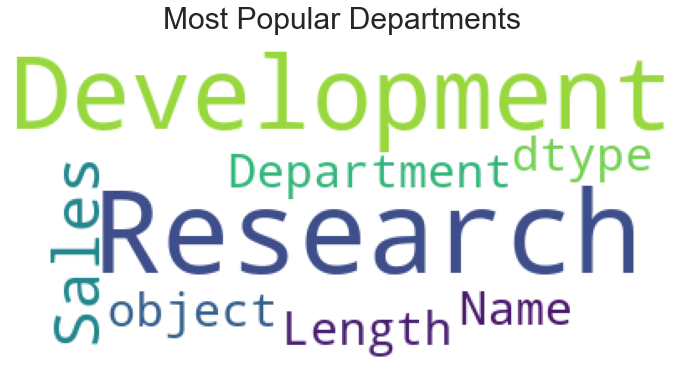

In [18]:
# Department Analysis
# Looking at the most popular departments
words_popular(general,'Department','Most Popular Departments')


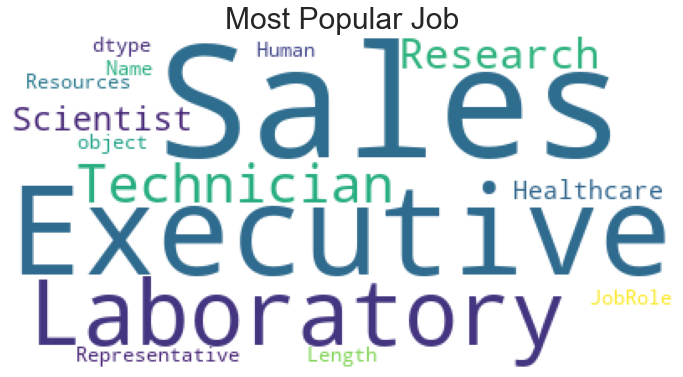

In [19]:
# Job Role Analysis
words_popular(general,'JobRole','Most Popular Job')


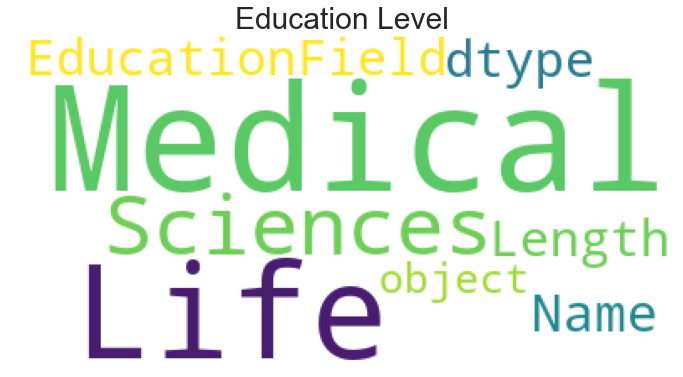

In [20]:
words_popular(general,'EducationField','Education Level')

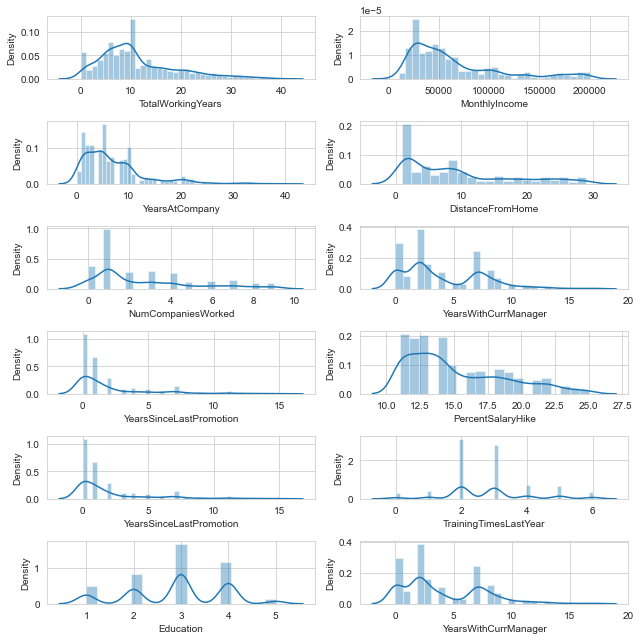

In [21]:

fig,ax = plt.subplots(6,2, figsize=(9,9))
sns.distplot(general['TotalWorkingYears'], ax = ax[0,0])
sns.distplot(general['MonthlyIncome'], ax = ax[0,1])
sns.distplot(general['YearsAtCompany'], ax = ax[1,0])
sns.distplot(general['DistanceFromHome'], ax = ax[1,1])
sns.distplot(general['NumCompaniesWorked'], ax = ax[2,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[2,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[3,0])
sns.distplot(general['PercentSalaryHike'], ax = ax[3,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[4,0])
sns.distplot(general['TrainingTimesLastYear'], ax = ax[4,1])
sns.distplot(general['Education'], ax = ax[5,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[5,1])
plt.tight_layout()
plt.show()


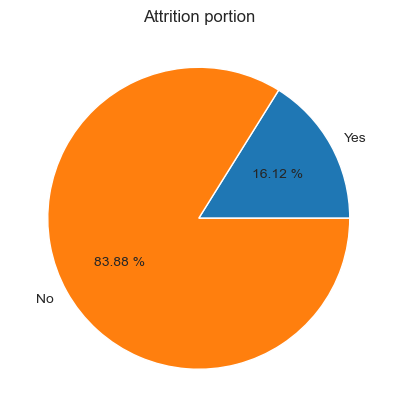

In [22]:
# Portion of Attrition
types = ['Yes', 'No']

# Portion of male/female
plt.figure(figsize = (10,5), dpi = 100)

leave = general.loc[general['Attrition'] == types[0]].count()[0]
stay = general.loc[general['Attrition'] == types[1]].count()[0]

plt.pie([leave, stay], labels = types, autopct = '%.2f %%')
plt.title('Attrition portion')

plt.show()

#sns.factorplot(data = general, kind = 'count', size = 5, aspect = 3, x = 'Attrition')

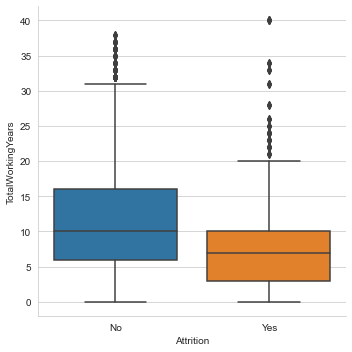

In [23]:
sns.factorplot(data=general,y='TotalWorkingYears',x='Attrition',size=5,aspect=1,kind='box')

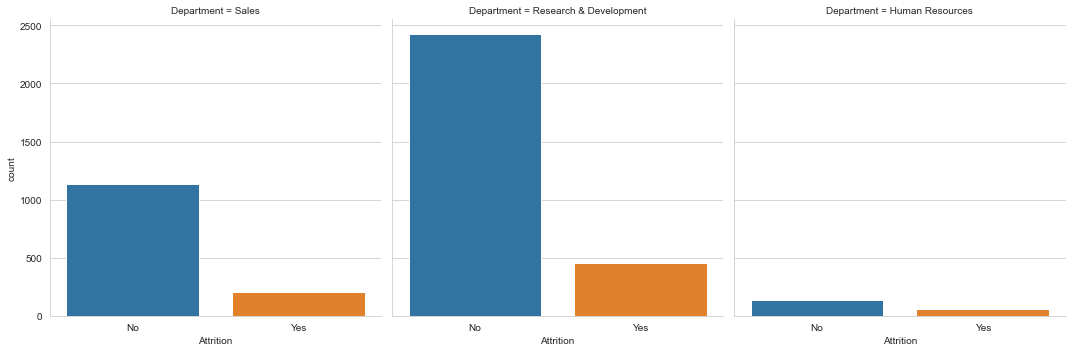

In [24]:
sns.factorplot(data=general,kind='count',x='Attrition',col='Department')


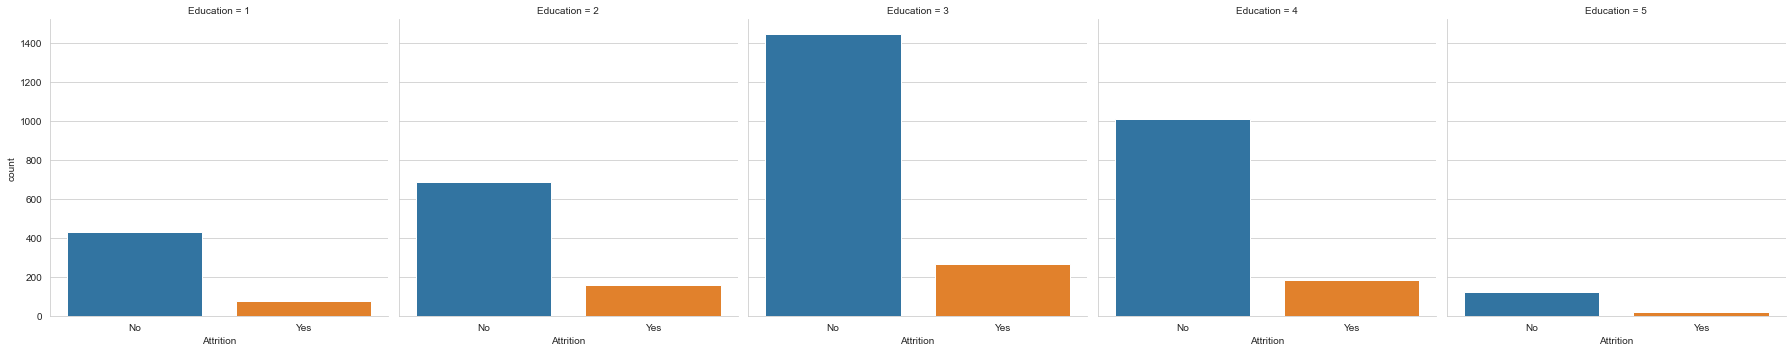

In [25]:
sns.factorplot(data=general,kind='count',x='Attrition',col='Education')


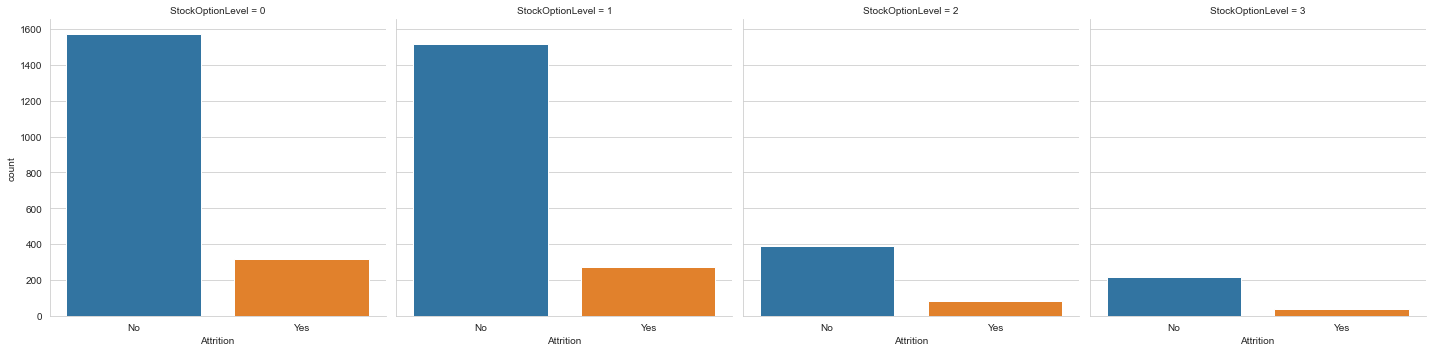

In [26]:
sns.factorplot(data=general,kind='count',x='Attrition',col='StockOptionLevel')


In [27]:
# Performance rating distribution
ratings = manager_survey['PerformanceRating'].unique()
print(ratings)

[3 4]


In [28]:
general.head(30)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,3.0,Y,13,8,0,28.0,5,7,7,7
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,2.0,Y,20,8,1,5.0,2,0,0,0
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,2.0,Y,22,8,3,10.0,2,0,0,0
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,0.0,Y,21,8,0,10.0,2,9,7,8
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,1.0,Y,13,8,1,6.0,2,6,1,5


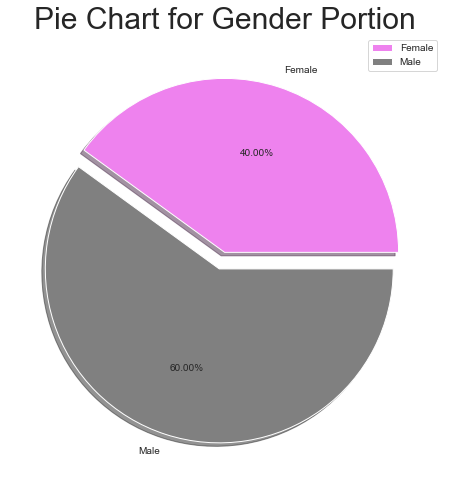

In [29]:
# A Pie chart representing the portion of gender 
counts = general.groupby(['Gender'])['EmployeeID'].count()
female_count = counts.loc["Female",]
male_count = counts.loc['Male',]

# Plotting pie chart
size = [female_count,male_count]
labels = ['Female','Male']
colors = ['violet','grey']
explode = [0,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Pie Chart for Gender Portion', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()


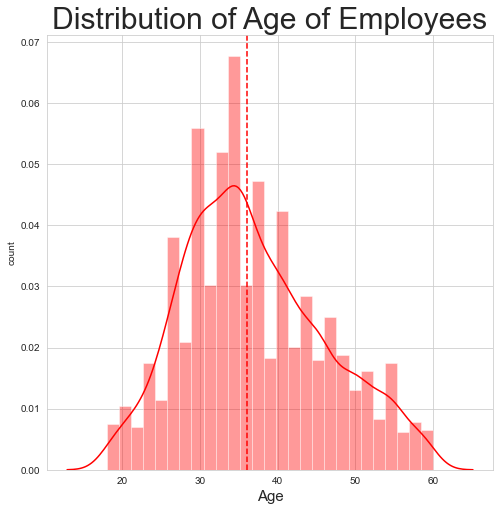

In [30]:
# Distribution of Age of Employees
sns.distplot(general['Age'], color = 'red')
plt.title('Distribution of Age of Employees', fontsize = 30)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('count')
plt.axvline(np.median(general['Age']), 0, linestyle='--', linewidth=1.5, color='r')
plt.show()

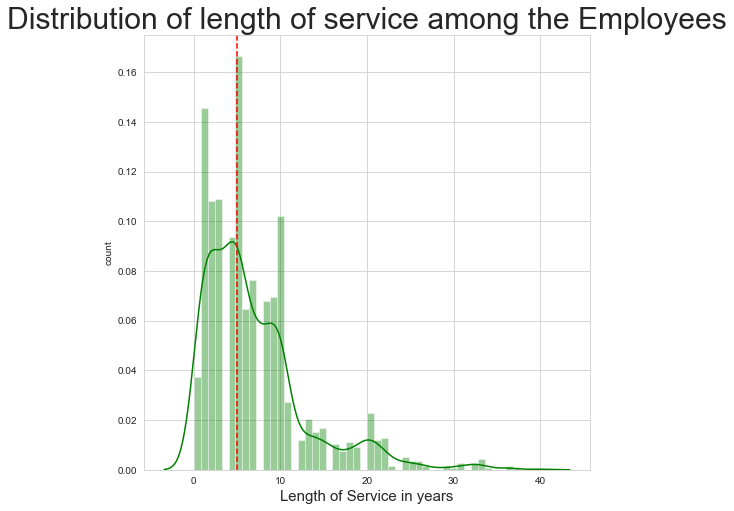

In [31]:
# checking the distribution of length of service
sns.distplot(general['YearsAtCompany'], color = 'green')
plt.title('Distribution of length of service among the Employees', fontsize = 30)
plt.xlabel('Length of Service in years', fontsize = 15)
plt.ylabel('count')
plt.axvline(np.median(general['YearsAtCompany']), 0, linestyle='--', linewidth=1.5, color='r')
plt.show()

The Distribution of length of service is left-skewed. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


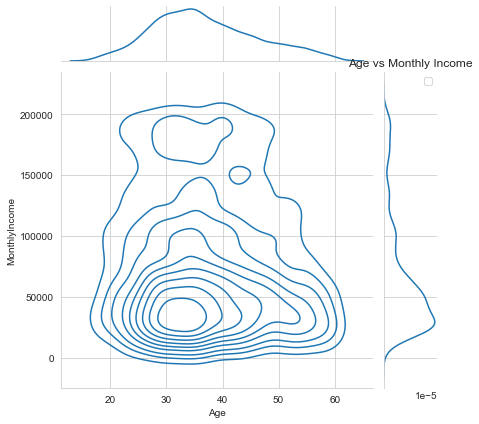

In [32]:
sns.jointplot(x="Age", y="MonthlyIncome", data=general, kind='kde')
plt.xlabel('Age')
plt.ylabel('MonthlyIncome')
plt.title('Age vs Monthly Income')

plt.legend()
plt.show()

In [35]:

# Generate a copy of employee, name it employee clean and remove its isnull rows
# Remove all isnull rows
employee_clean = employee.copy(deep = True)
employee_clean = employee_clean.dropna()

print(employee_clean.shape)
print('-'*50)
print(employee.shape)

(4327, 4)
--------------------------------------------------
(4410, 4)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


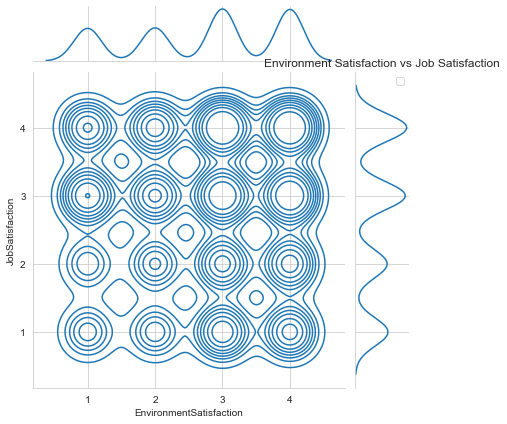

In [36]:
sns.jointplot(x="EnvironmentSatisfaction", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Job Satisfaction')
plt.title('Environment Satisfaction vs Job Satisfaction')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


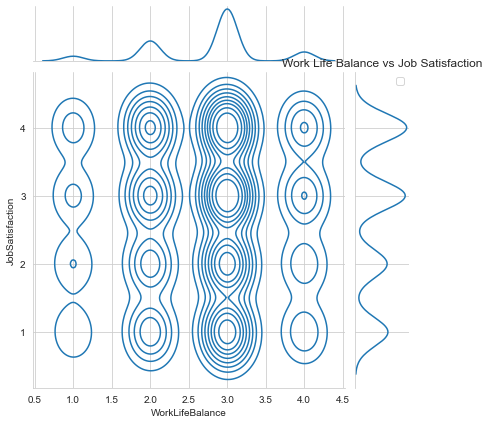

In [37]:
sns.jointplot(x="WorkLifeBalance", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Work Life Balance')
plt.ylabel('Job Satisfaction')
plt.title('Work Life Balance vs Job Satisfaction')

plt.legend()
plt.show()

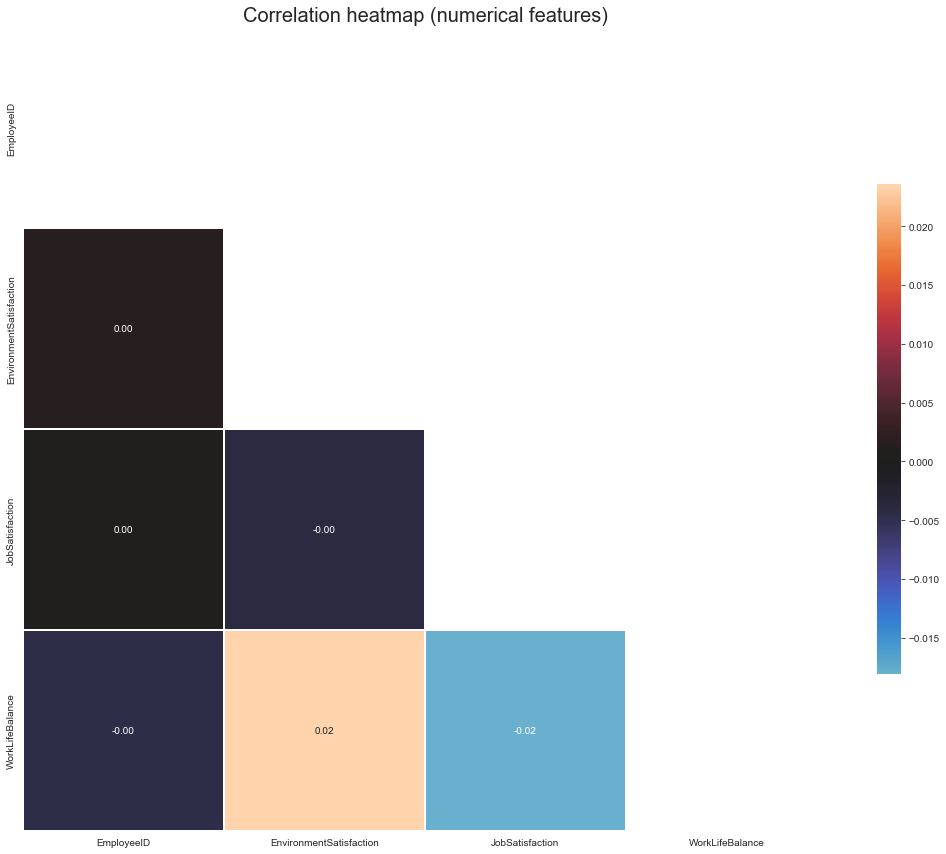

In [38]:
# Generate heatmap about employee table
f,ax = plt.subplots(figsize=(18, 18))
corr = employee_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

From the visualizations carried above we have come to understand the following about the employees who left the firm:

The employees who left the firm did indeed have a better performance than the
employees who stayed with the firm.

The employees who left the firm had lower satisfaction levels
The employees who left the firm were made to work longer hours monthly.
The management department stayed the longest number of years with the firm
suggesting that the employees in the other departments could have had issues with the management.

Employees who were given lesser projects were more likely to leave the firm.
Employees having a mid level salary were more likely to leave the firm.
Employees who worked really less number of hours or worked a high number of
hours were more likely to leave the firm.

Employee were more likely to leave the firm after working for 3 years.

Data Pre-processing

In [45]:
# Data Merge 
dataset = general.merge(employee)
dataset.head(5)
# drop over18 column in dataset
dataset = dataset.drop(columns = ['Over18'])

# Data mapping
#business_travel_map = {'Travel_Rarely': 1,'Travel_Frequently':2, 'Non-Travel': 0}
#dataset['Education'] = dataset['Education'].apply(lambda x: business_travel_map[x])






In [ ]:
# Separate Y and other factors
Y = dataset['Attrition']
X = dataset['']

Oversampling of the Model

In [ ]:

from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_sample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

In [ ]:

# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 0)

print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_valid.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_valid.shape)

In [ ]:
# standard scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

Applying PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = None)
x_train = pca.fit_transform(general)
x_test = pca.transform(general)
x_valid = pca.transform(general)

Xgboost Algorithm

In [ ]:
# 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score